<a href="https://colab.research.google.com/github/roshanappa/Clustering-Of-Mixed-Datatypes/blob/main/Sales_Data_Kprototypes_Clsutering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- One of the conventional clustering methods commonly used in clustering techniques and efficiently used for large data is the K-Means algorithm. However, its method is not good and suitable for data that contains categorical variables. This problem happens when the cost function in K-Means is calculated using the Euclidian distance that is only suitable for numerical data. While K-Mode is only suitable for categorical data only, not mixed data types.
Facing these problems, Huang proposed an algorithm called K-Prototype which is created in order to handle clustering algorithms with the mixed data types (numerical and categorical variables). K-Prototype is a clustering method based on partitioning. Its algorithm is an improvement of the K-Means and K-Mode clustering algorithm to handle clustering with the mixed data types.

- Note: K-Prototype has an advantage because it’s not too complex and is able to handle large data and is better than hierarchical based algorithms.



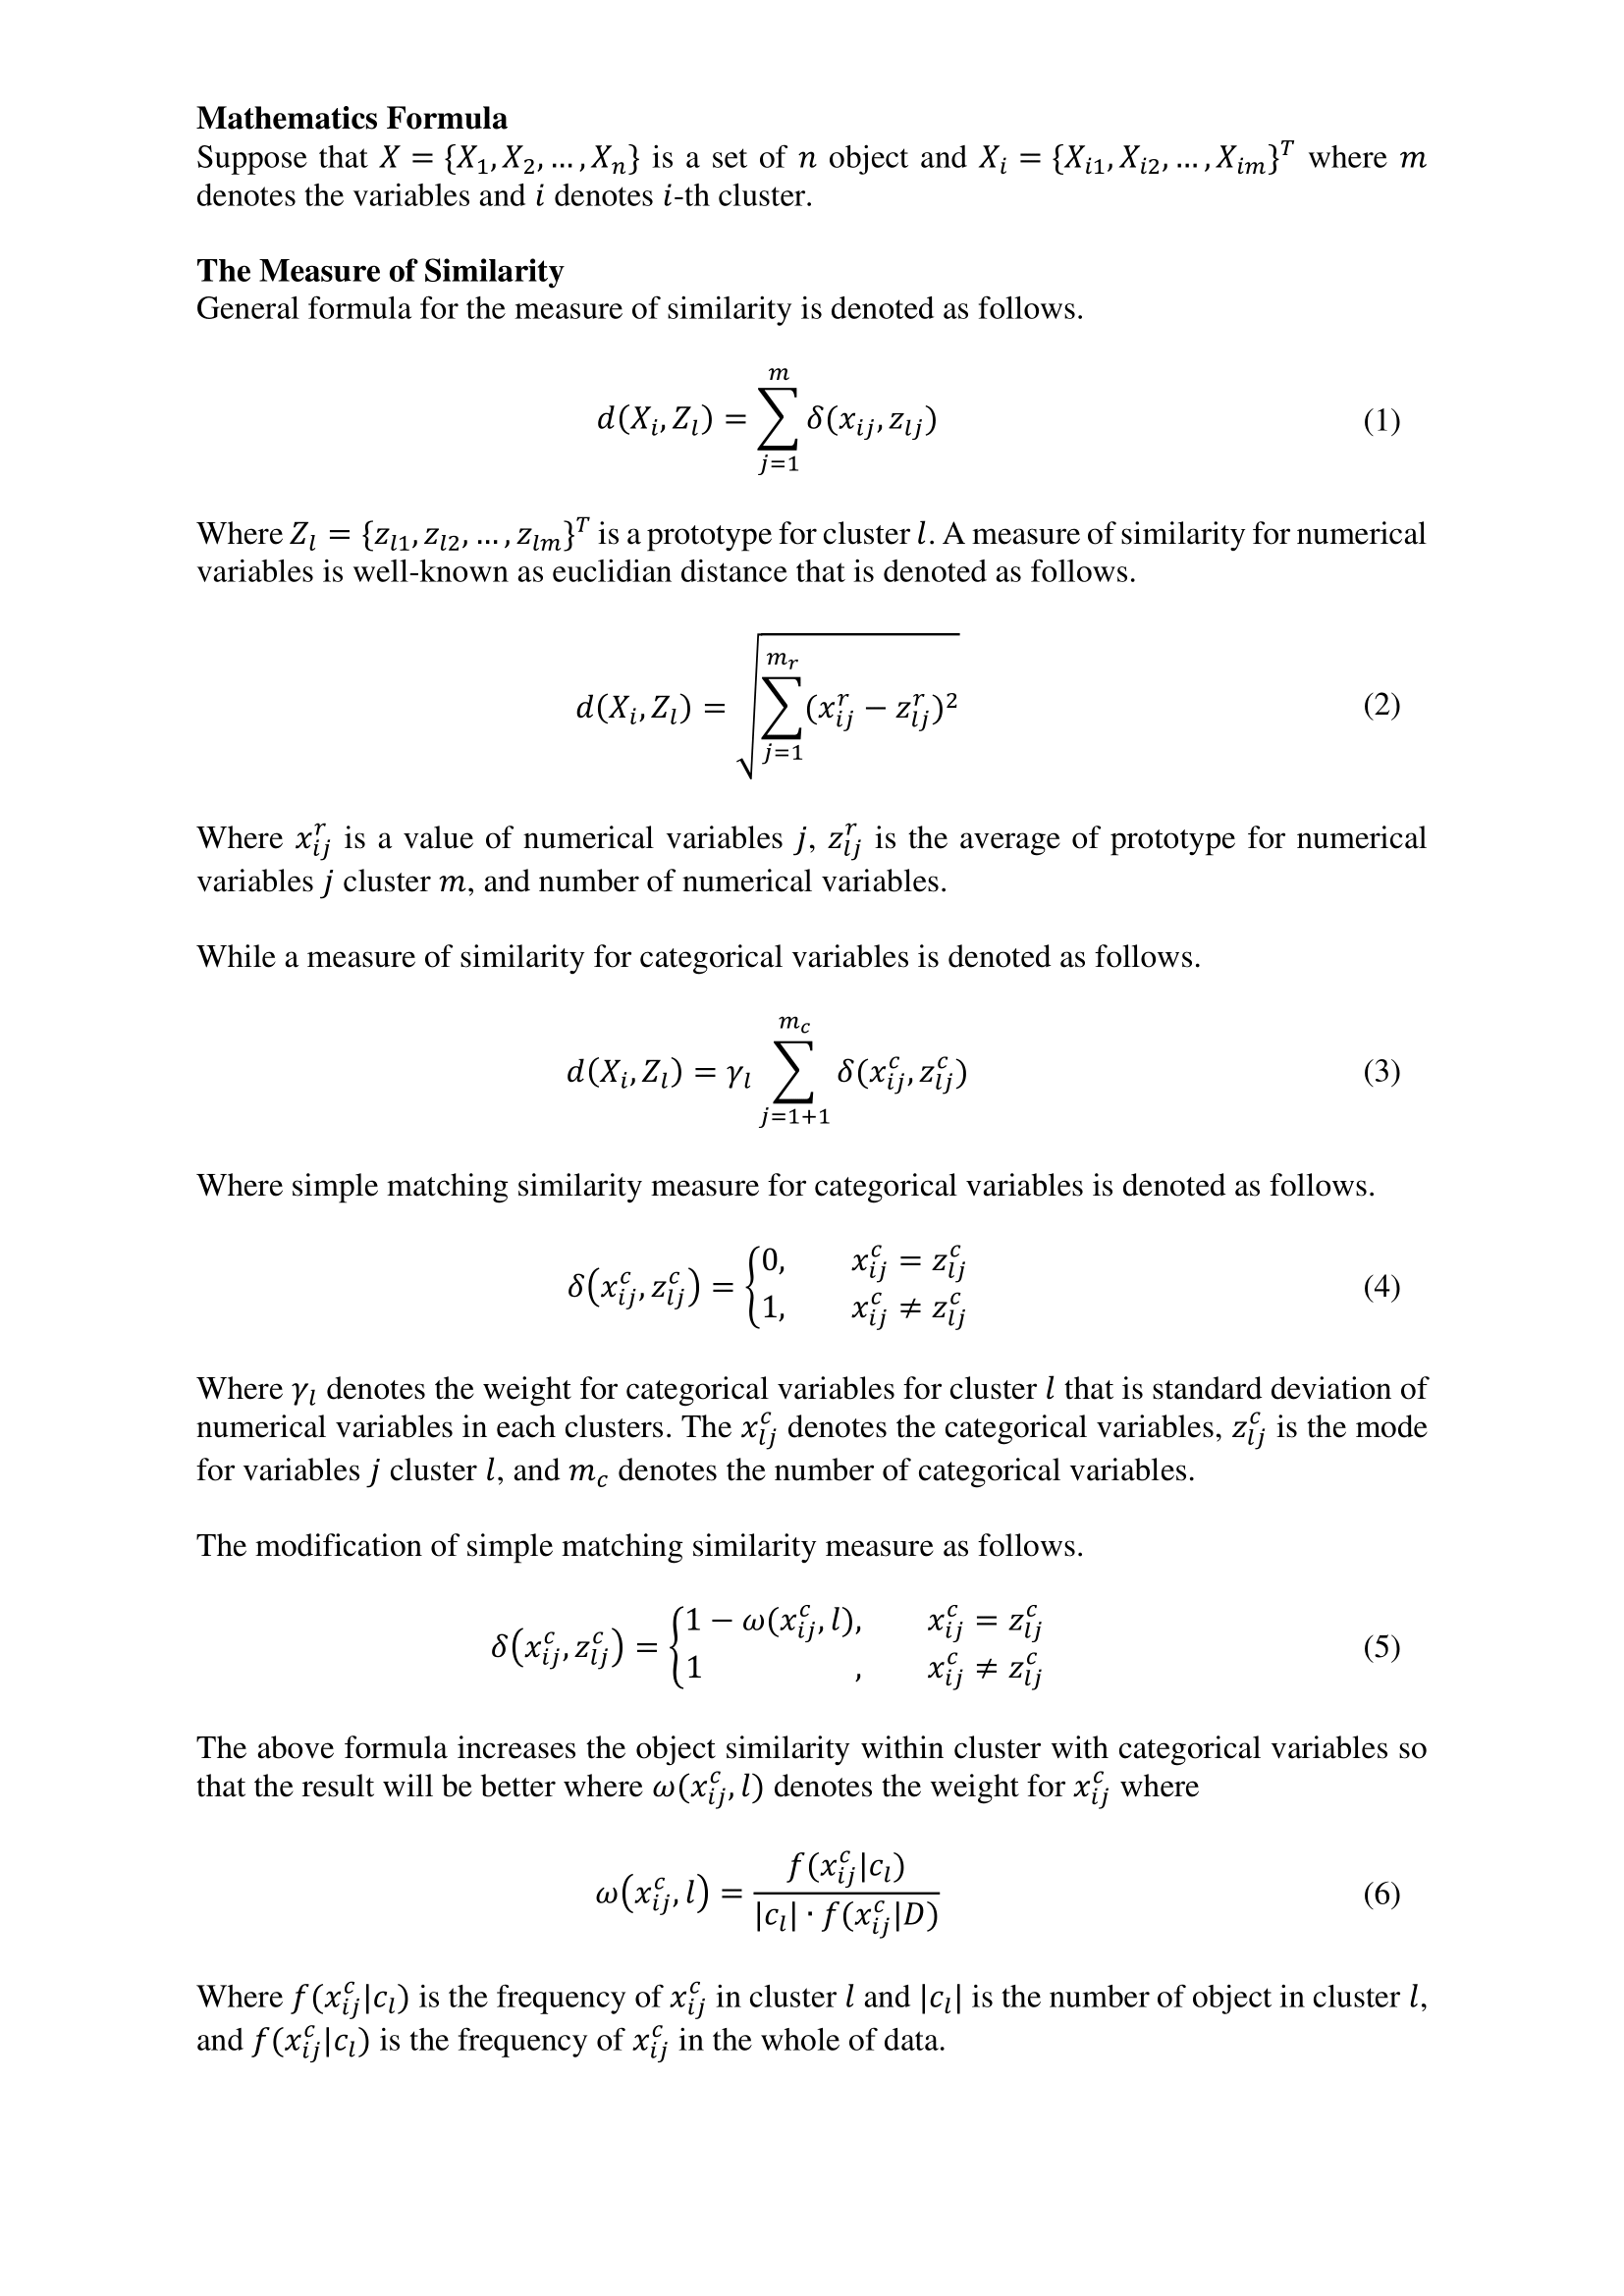

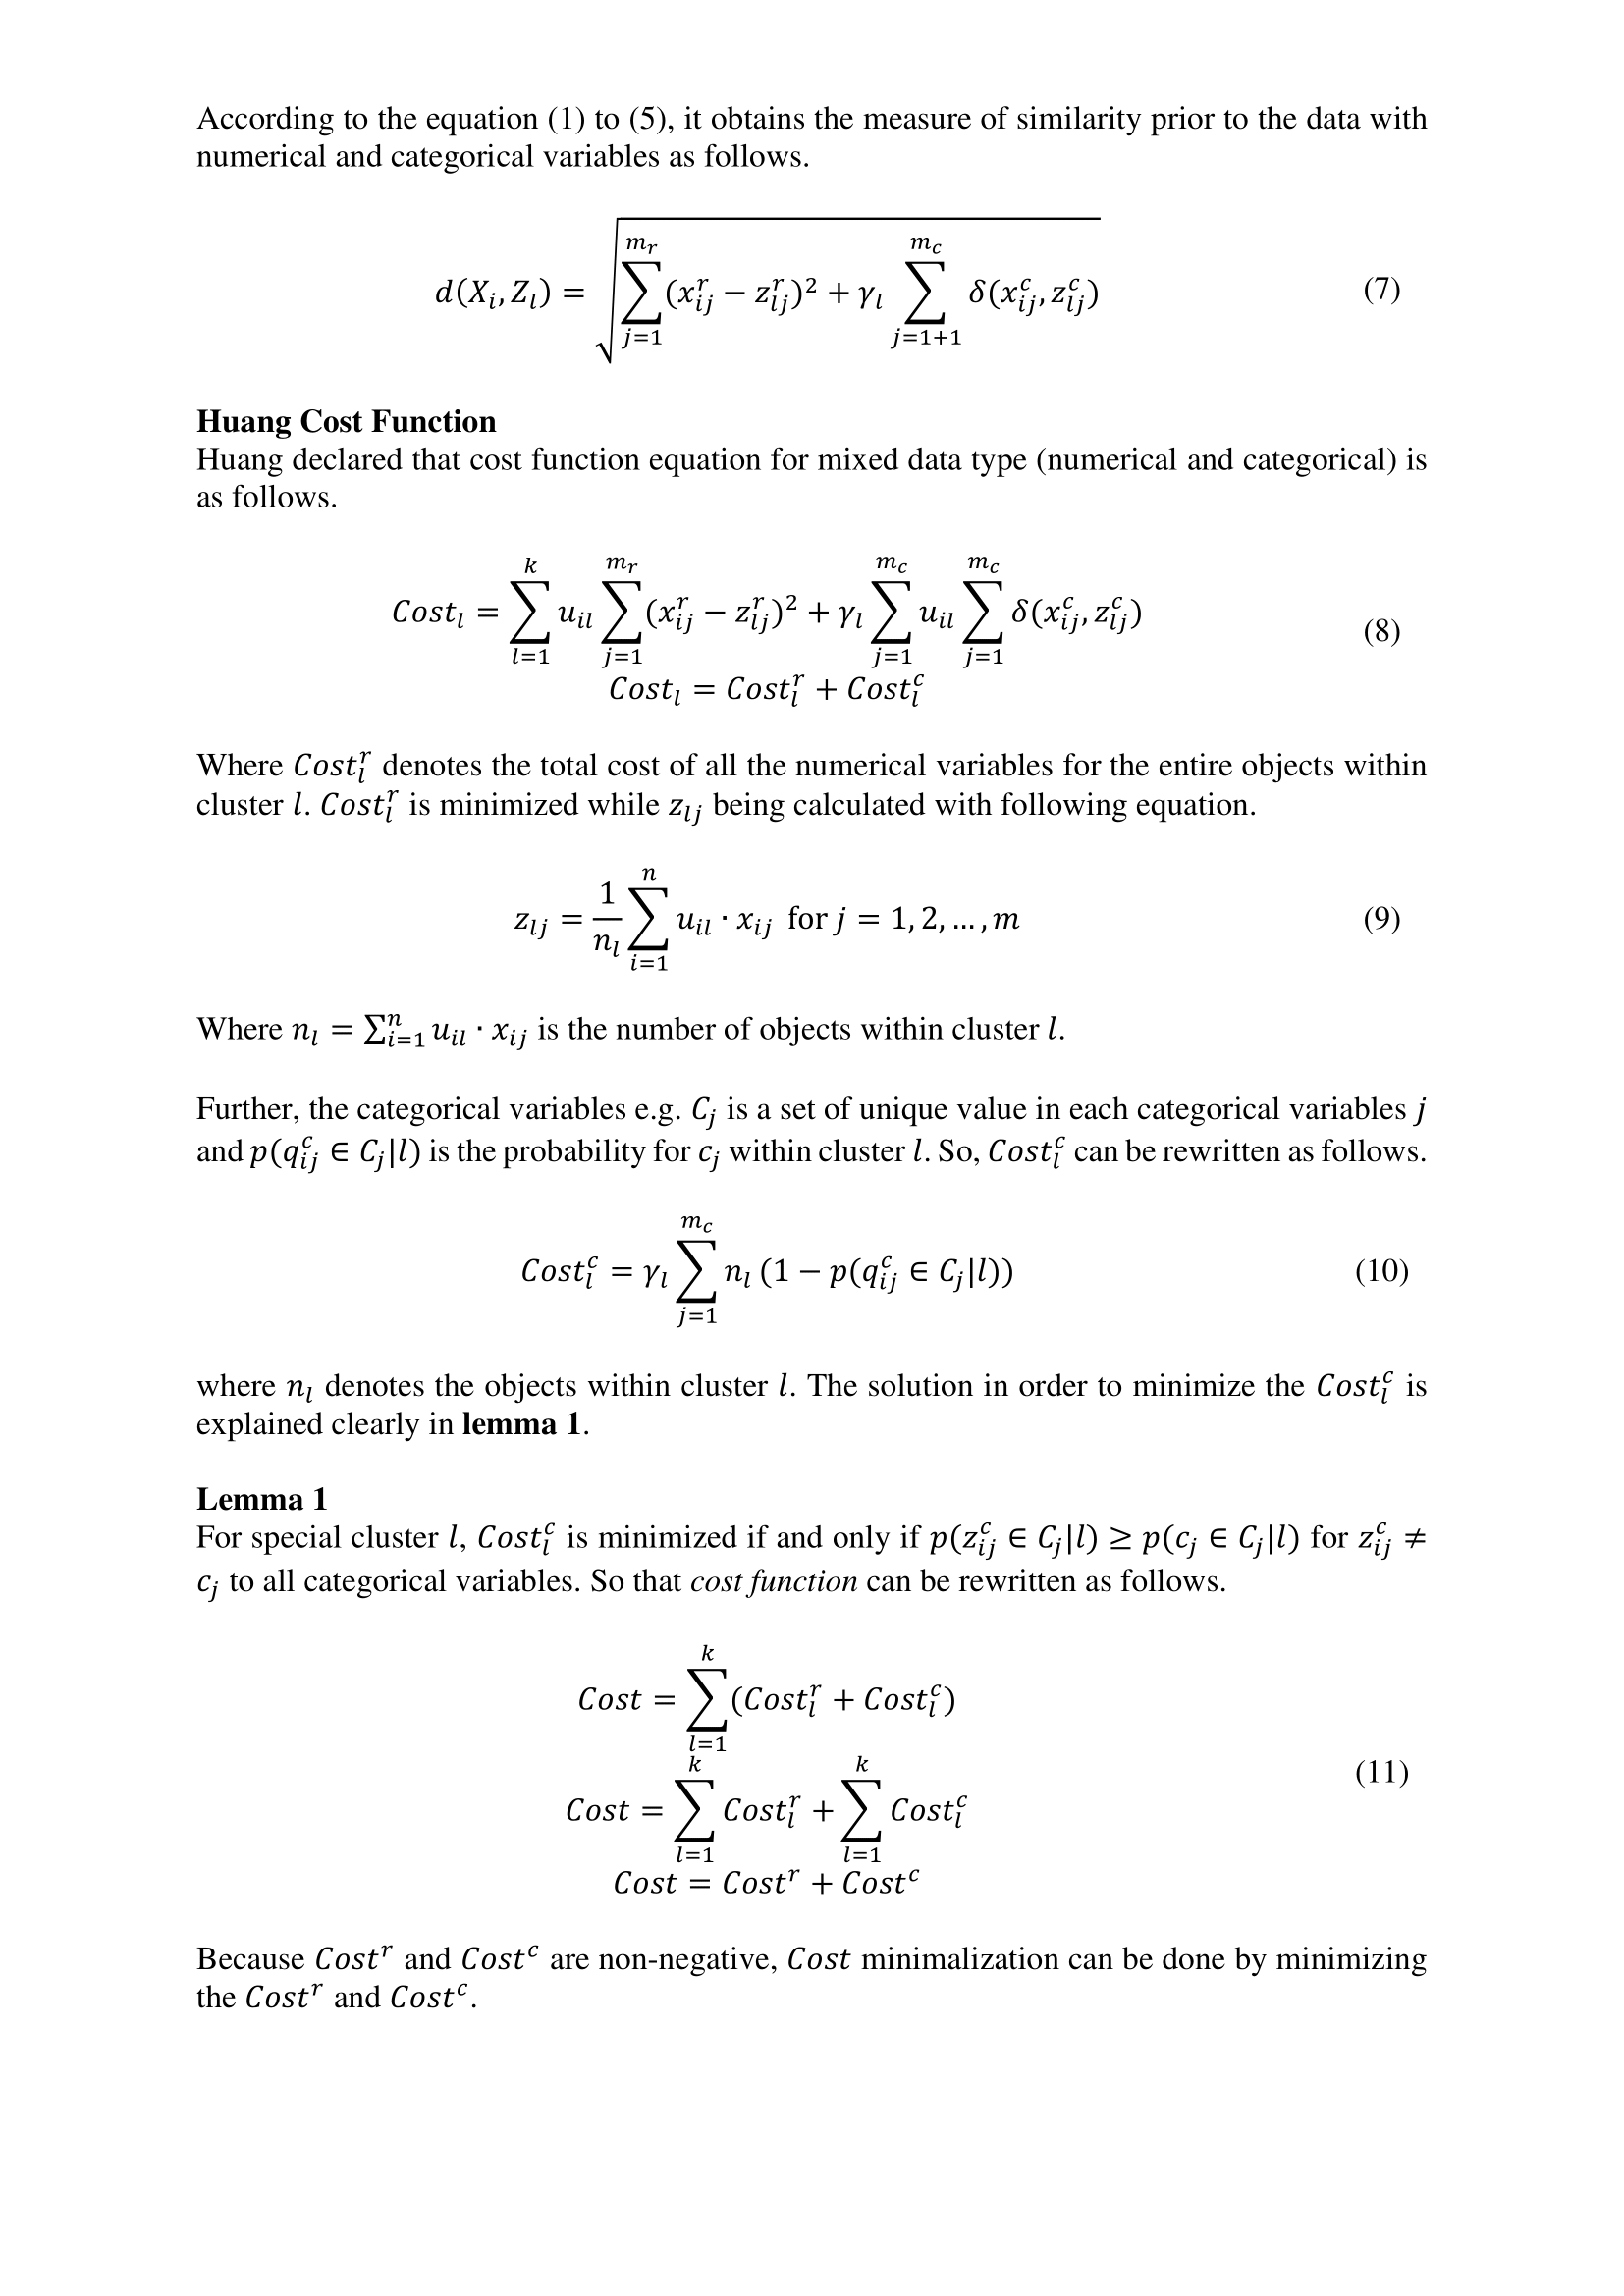

## The application of K-Prototype
In this part, we will demonstrate the implementation of K-Prototype using Python. Before that, it’s important to install the kmodes module first using the terminal or Anaconda prompt.
There are a few modules used for demonstration. They are pandas for data manipulation, numpy for linear algebra calculation, plotnine as data visualization, and kmodes for K-Prototype clustering algorithm.

In [21]:
!pip install kmodes

In [22]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
from plotnine import *
import plotnine
# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

The data is actually the Country Sales Data. The data has 10,000 rows and 14 columns with mixed data types (numerical and categorical). It records the transaction of sales by country around the world.

In [23]:
# Load the data
df = pd.read_csv('/content/10000 Sales Records.csv')
# The dimension of data
print('Dimension data: {} rows and {} columns'.format(len(df), len(df.columns)))
# Print the first 5 rows
df.head()

Dimension data: 10000 rows and 14 columns


,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Chad,Office Supplies,Online,L,1/27/2011,292494523,2/12/2011,4484,651.210,524.960,2920025.640,2353920.640,566105.000
1,Europe,Latvia,Beverages,Online,C,12/28/2015,361825549,1/23/2016,1075,47.450,31.790,51008.750,34174.250,16834.500
2,Middle East and North Africa,Pakistan,Vegetables,Offline,C,1/13/2011,141515767,2/1/2011,6515,154.060,90.930,1003700.900,592408.950,411291.950
3,Sub-Saharan Africa,Democratic Republic of the Congo,Household,Online,C,9/11/2012,500364005,10/6/2012,7683,668.270,502.540,5134318.410,3861014.820,1273303.590
4,Europe,Czech Republic,Beverages,Online,C,10/27/2015,127481591,12/5/2015,3491,47.450,31.790,165647.950,110978.890,54669.060


To make sure the data type of each column is mapped properly, we must inspect their type manually using df.info() command. If we found there is false mapping, we should correct it to the right data type.

In [24]:
# Inspect the data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          10000 non-null  object 
 1   Country         10000 non-null  object 
 2   Item Type       10000 non-null  object 
 3   Sales Channel   10000 non-null  object 
 4   Order Priority  10000 non-null  object 
 5   Order Date      10000 non-null  object 
 6   Order ID        10000 non-null  int64  
 7   Ship Date       10000 non-null  object 
 8   Units Sold      10000 non-null  int64  
 9   Unit Price      10000 non-null  float64
 10  Unit Cost       10000 non-null  float64
 11  Total Revenue   10000 non-null  float64
 12  Total Cost      10000 non-null  float64
 13  Total Profit    10000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 1.1+ MB


There are seven categorical variables in the dataset. The Country that has the 185 unique values, Order Date with 2691 unique values, and Ship Date with 2719 unique values will be removed from cluster analysis because they have a lot of unique values. The rest of the columns will be kept. They are Region with 7 unique values, Item Type with 12 unique values, Sales Channel that has the 2 unique values and Order Priority with 4 unique values.
# Inspect The categorical Values

The rest of the columns are numerical variables. They are Order ID, Units Sold, Unit Price, Units Cost, Total Revenue, Total Cost, and Total Profit.

In [25]:
# Inspect the categorical variables
df.select_dtypes('object').nunique()

Region               7
Country            185
Item Type           12
Sales Channel        2
Order Priority       4
Order Date        2691
Ship Date         2719
dtype: int64

# Inspect the numerical variables

In [26]:
df.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,549871874.366,5002.856,268.143,188.807,1333355.131,938265.784,395089.347
std,260783511.133,2873.246,217.944,176.446,1465026.174,1145914.069,377554.961
min,100089156.000,2.000,9.330,6.920,167.940,124.560,43.380
25%,321806669.000,2530.750,109.280,56.670,288551.078,164785.530,98329.140
50%,548566305.000,4962.000,205.700,117.110,800051.210,481605.840,289099.020
75%,775998103.500,7472.000,437.200,364.690,1819143.390,1183821.520,566422.708
max,999934232.000,10000.000,668.270,524.960,6680026.920,5241725.600,1738178.390


The last task before going to data exploration and analysis is to make sure the data doesn’t contain missing values.

In [27]:
# Check missing value
df.isna().sum()

Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Unit Price        0
Unit Cost         0
Total Revenue     0
Total Cost        0
Total Profit      0
dtype: int64

Before going to cluster analysis, we should do data exploration for descriptive analysis. It aims to find out an interesting point that can be useful for report generating and capture the phenomenon in the data.
We have the hypothesis that the number of purchases in each region has a strong linear correlation to the total profit. To conclude this, we have two options, descriptive analysis, and inference analysis. For this section, we will choose the first option. Let’s see!

In [28]:
# The distribution of sales each region
df_region = pd.DataFrame(df['Region'].value_counts()).reset_index()
df_region['Percentage'] = df_region['Region'] / df['Region'].value_counts().sum()
df_region.rename(columns = {'index':'Region', 'Region':'Total'}, inplace = True)
df_region = df_region.sort_values('Total', ascending = True).reset_index(drop = True)
df_region

,Region,Total,Percentage
0,North America,215,0.021
1,Australia and Oceania,797,0.080
2,Central America and the Caribbean,1019,0.102
3,Middle East and North Africa,1264,0.126
4,Asia,1469,0.147
5,Sub-Saharan Africa,2603,0.260
6,Europe,2633,0.263


In [29]:
# The dataframe
df_region = df.groupby('Region').agg({
    'Region': 'count',
    'Units Sold': 'mean',
    'Total Revenue': 'mean',
    'Total Cost': 'mean',
    'Total Profit': 'mean'
    }
).rename(columns = {'Region': 'Total'}).reset_index().sort_values('Total', ascending = True)
df_region

,Region,Total,Units Sold,Total Revenue,Total Cost,Total Profit
5,North America,215,5373.358,1559778.805,1097008.967,462769.838
1,Australia and Oceania,797,4986.769,1317192.267,910578.451,406613.816
2,Central America and the Caribbean,1019,5081.063,1369509.041,973672.093,395836.948
4,Middle East and North Africa,1264,5116.219,1357304.982,953884.180,403420.803
0,Asia,1469,5015.488,1365082.080,965215.983,399866.097
6,Sub-Saharan Africa,2603,4967.808,1287190.079,903155.468,384034.611
3,Europe,2633,4920.385,1322207.396,932158.169,390049.226


From the above result, we can conclude that North America is the region with the lowest number of sales but they outperform all regions in certain columns such as Units Sold, Total Revenue, Total Cost, and Total Profit. Unlike other regions, North America makes many purchases at the same time. While Europe that has the highest number of purchases doesn’t contribute to the total profit significantly. It means that the number of purchases is not having a strong linear correlation to the total profit.

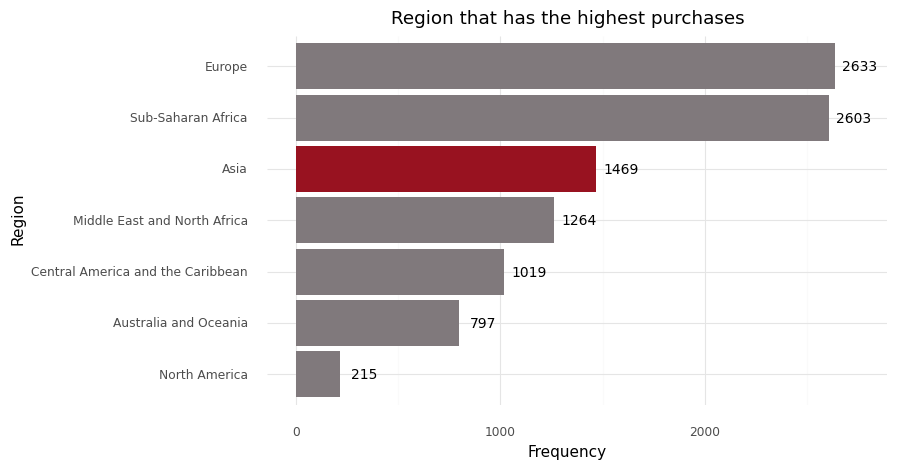

<ggplot: (8754856294209)>

In [30]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_region)+
    geom_bar(aes(x = 'Region',
                 y = 'Total'),
             fill = np.where(df_region['Region'] == 'Asia', '#981220', '#80797c'),
             stat = 'identity')+
    geom_text(aes(x = 'Region',
                   y = 'Total',
                   label = 'Total'),
               size = 10,
               nudge_y = 120)+
    labs(title = 'Region that has the highest purchases')+
    xlab('Region')+
    ylab('Frequency')+
    scale_x_discrete(limits = df_region['Region'].tolist())+
    theme_minimal()+
    coord_flip()
)

For the data exploration, we will create a cross-tabulation between Region and Item Type to look out for any patterns.

In [31]:
# Order the index of cross tabulation
order_region = df_region['Region'].to_list()
order_region.append('All')
# distribution of item type
df_item = pd.crosstab(df['Region'], df['Item Type'], margins = True).reindex(order_region, axis = 0).reset_index()
# Remove index name
df_item.columns.name = None
df_item

,Region,Baby Food,Beverages,Cereal,Clothes,Cosmetics,Fruits,Household,Meat,Office Supplies,Personal Care,Snacks,Vegetables,All
0,North America,21,20,16,21,20,15,20,17,20,17,16,12,215
1,Australia and Oceania,65,50,69,77,75,55,78,61,50,76,72,69,797
2,Central America and the Caribbean,74,92,77,84,77,81,104,75,94,82,89,90,1019
3,Middle East and North Africa,105,96,104,111,99,104,128,101,103,112,95,106,1264
4,Asia,132,108,121,116,125,111,116,114,132,137,120,137,1469
5,Sub-Saharan Africa,235,220,211,229,203,230,218,207,207,223,221,199,2603
6,Europe,210,196,227,234,235,199,211,223,231,241,203,223,2633
7,All,842,782,825,872,834,795,875,798,837,888,816,836,10000


Data pre-processing aims to remove the unused columns which are Country, Order Date, Order ID, and Ship Date. They are irrelevant regarding the K-Prototype clustering algorithm. There are two reasons why we need to remove these columns as follows:

- Country — it has a lot of unique values that add to the computational load. The information is too much to process and becomes meaningless
- Order Date and Ship Date — the clustering algorithm needs the assumption that the rows in the data represent the unique observation observed in a certain time period
- Order ID — it has meaningless information to the cluster analysis

In [32]:
# Data pre-processing
df.drop(['Country', 'Order Date', 'Order ID', 'Ship Date'], axis = 1, inplace = True)
# Show the data after pre-processing
print('Dimension data: {} rows and {} columns'.format(len(df), len(df.columns)))
df.head()

Dimension data: 10000 rows and 10 columns


,Region,Item Type,Sales Channel,Order Priority,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,Office Supplies,Online,L,4484,651.210,524.960,2920025.640,2353920.640,566105.000
1,Europe,Beverages,Online,C,1075,47.450,31.790,51008.750,34174.250,16834.500
2,Middle East and North Africa,Vegetables,Offline,C,6515,154.060,90.930,1003700.900,592408.950,411291.950
3,Sub-Saharan Africa,Household,Online,C,7683,668.270,502.540,5134318.410,3861014.820,1273303.590
4,Europe,Beverages,Online,C,3491,47.450,31.790,165647.950,110978.890,54669.060


The K-Prototype clustering algorithm in kmodes module needs categorical variables or columns position in the data. This task aims to save those in a given variables catColumnsPos. It will be added for the next task in cluster analysis. The categorical column position is in the first four columns in the data.

In [35]:
# Get the position of categorical columns
catColumnsPos = [df.columns.get_loc(col) for col in list(df.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(df.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['Region', 'Item Type', 'Sales Channel', 'Order Priority']
Categorical columns position  : [0, 1, 2, 3]


Next, convert the data from the data frame to the matrix. It helps the kmodes module running the K-Prototype clustering algorithm. Save the data matrix to the variable dfMatrix.

In [36]:
# Convert dataframe to matrix
dfMatrix = df.to_numpy()
dfMatrix

array([['Sub-Saharan Africa', 'Office Supplies', 'Online', ...,
        2920025.64, 2353920.64, 566105.0],
       ['Europe', 'Beverages', 'Online', ..., 51008.75, 34174.25,
        16834.5],
       ['Middle East and North Africa', 'Vegetables', 'Offline', ...,
        1003700.9, 592408.95, 411291.95],
       ...,
       ['Sub-Saharan Africa', 'Vegetables', 'Offline', ..., 388847.44,
        229507.32, 159340.12],
       ['Sub-Saharan Africa', 'Meat', 'Online', ..., 3672974.34,
        3174991.14, 497983.2],
       ['Asia', 'Snacks', 'Offline', ..., 55081.38, 35175.84, 19905.54]],
      dtype=object)

We are using the Elbow method to determine the optimal number of clusters for K-Prototype clusters. Instead of calculating the within the sum of squares errors (WSSE) with Euclidian distance, K-Prototype provides the cost function that combines the calculation for numerical and categorical variables. We can look into the Elbow to determine the optimal number of clusters.

In [39]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 42)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6


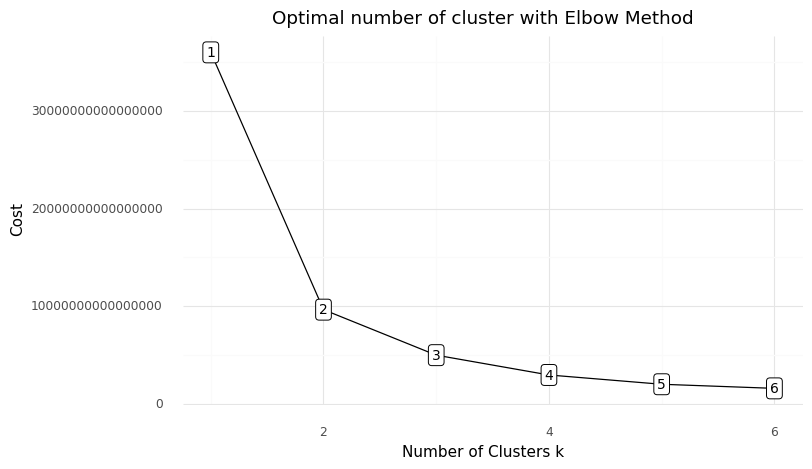

<ggplot: (8754855316177)>

In [41]:

# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

According to the scree plot of cost function above, we consider choosing the number of cluster k = 3. It will be the optimal number of clusters for K-Prototype cluster analysis. Read more about the Elbow method HERE.
Link :- https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92

In [42]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([2, 1, 1, ..., 1, 0, 1], dtype=uint16)

The algorithm has 7 iterations to converge and it has a cost of 4,960,713,581,025,175.0 (it’s quite big right?!). We can print the centroids of cluster using kprototype.cluster_centroids_. For the numerical variables, it will be using the average while the categorical using the mode.

In [43]:
# Cluster centorid
kprototype.cluster_centroids_
# Check the iteration of the clusters created
kprototype.n_iter_
# Check the cost of the clusters created
kprototype.cost_

4960713581025175.0

The interpretation of clusters is needed. The interpretation is using the centroids in each cluster. To do so, we need to append the cluster labels to the raw data. Order the cluster labels will be helpful to arrange the interpretation based on cluster labels.

In [44]:
# Add the cluster to the dataframe
df['Cluster Labels'] = kprototype.labels_
df['Segment'] = df['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third'})
# Order the cluster
df['Segment'] = df['Segment'].astype('category')
df['Segment'] = df['Segment'].cat.reorder_categories(['First','Second','Third'])

To interpret the cluster, for the numerical variables, it will be using the average while the categorical using the mode. But there are other methods that can be implemented such as using median, percentile, or value composition for categorical variables.

In [45]:
# Cluster interpretation
df.rename(columns = {'Cluster Labels':'Total'}, inplace = True)
df.groupby('Segment').agg(
    {
        'Total':'count',
        'Region': lambda x: x.value_counts().index[0],
        'Item Type': lambda x: x.value_counts().index[0],
        'Sales Channel': lambda x: x.value_counts().index[0],
        'Order Priority': lambda x: x.value_counts().index[0],
        'Units Sold': 'mean',
        'Unit Price': 'mean',
        'Total Revenue': 'mean',
        'Total Cost': 'mean',
        'Total Profit': 'mean'
    }
).reset_index()


,Segment,Total,Region,Item Type,Sales Channel,Order Priority,Units Sold,Unit Price,Total Revenue,Total Cost,Total Profit
0,First,1190,Europe,Household,Offline,L,7904.366,593.527,4622760.548,3559121.123,1063639.424
1,Second,6381,Sub-Saharan Africa,Personal Care,Online,C,4046.669,163.259,467709.452,281142.955,186566.497
2,Third,2429,Europe,Cosmetics,Online,H,6093.275,384.265,1995888.123,1380539.527,615348.596


The K-Prototype is the clustering algorithm which is the combination of K-Means and K-Mode developed by Huang. For the implementation of its algorithm, the researcher needs to filter the columns carefully especially for the categorical variables. The categorical variables must be relevant to the analysis which is not meaningless information. Besides that, the quality of the input (data) affects the clustering result (cluster initialization) and how the algorithm processes the data to get the converged result. As the researcher, for the final task, interpretation, we need to consider the metrics to use for both numerical and categorical variables.

## Thank  You !!